# <center> Predicting Zebrafish Movements in Virtual Reality

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from IPython.display import display


## Context

This project is part of a collaboration between EPFL and UNIL.
It aims to understand the perceptual and computational rules underlying social interactions in zebrafish through behavioral and neural data analysis.

In this experiment, a single zebrafish swims in a controlled environment equipped with a virtual reality system.  
One or several visual stimuli (dots) are projected on a screen, simulating the motion patterns of another fish, typically a sequence of “bursts and glides” characteristic of zebrafish swimming behavior.  
The fish’s trajectory, orientation, and velocity are continuously tracked, as well as the trajectories and properties of the stimuli.

## Objective

The goal of this notebook is to use the preprocessed dataset (prepared in AllFish_GsizeMotionSingle notebook) to model and predict the future position of the fish** based on its past movements and the motion of the stimuli.  
This predictive approach will serve as a first computational prototype for understanding how fish integrate visual information and self-motion to generate coordinated behavior.

## Data description 

The dataset contains synchronized time series including:
- Fish positions (`f0_x`, `f0_y`) and orientations (`f0_ori`)
- Stimulus positions and attributes (`d0_x`, `d0_y`, `d0_stim`)
- Condition : Description of experiment

Each row corresponds to a time step in the experiment, allowing us to build temporal sequences that capture short-term dynamics of perception and movement.

## <center> Exploring dataset and preprocessing

In [2]:
df = pd.read_csv('preprocessed_data.csv')

df.head(-10)

,f0_x,f0_y,f0_ori,f1_x,f1_y,f1_ori,f2_x,f2_y,f2_ori,f3_x,...,d5_x,d5_y,d5_stim,d6_x,d6_y,d6_stim,d7_x,d7_y,d7_stim,condition
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,180,180,none,180,180,none,180,180,none,inter_stim_pause
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323985,221.0,179.0,6.144,108.0,183.0,1.242,232.0,154.0,6.057,207.0,...,180,180,none,180,180,none,180,180,none,bout
323986,220.0,179.0,6.170,108.0,183.0,1.240,232.0,154.0,6.064,207.0,...,180,180,none,180,180,none,180,180,none,bout
323987,221.0,179.0,6.141,108.0,183.0,1.225,233.0,154.0,6.081,207.0,...,180,180,none,180,180,none,180,180,none,bout
323988,221.0,179.0,6.137,108.0,183.0,1.220,232.0,154.0,6.075,207.0,...,180,180,none,180,180,none,180,180,none,bout


In [3]:
print("The dataset contains : " + str((df.isna().any(axis=1).mean() * 100)) + "% of NaN.") 
df = df.dropna()

The dataset contains : 0.2623456790123457% of NaN.


There are few NaN, therefore we make the choice to remove them.

In [4]:
df.dtypes.value_counts()

float64    45
int64      16
object      9
Name: count, dtype: int64

In [5]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols.tolist()

['d0_stim',
 'd1_stim',
 'd2_stim',
 'd3_stim',
 'd4_stim',
 'd5_stim',
 'd6_stim',
 'd7_stim',
 'condition']

In [6]:
unique_conditions = df['condition'].unique()
print(f"There are {len(unique_conditions)} unique conditions:\n")
for c in unique_conditions:
    print("-", c)

There are 18 unique conditions:

- inter_stim_pause
- CLsemi1800_g4-0_s3.5-3.5
- CLsemi1800_g0-2_s3.5-3.5
- CLsemi1800_g0-4_s3.5-3.5
- CLsemi1800_g8-0_s3.5-3.5
- CLsemi1800_g0-4_s0-0
- CLsemi1800_g8-0_s0-0
- CLsemi1800_g6-0_s3.5-3.5
- CLsemi1800_g0-8_s0-0
- CLsemi1800_g1-0_s3.5-3.5
- CLsemi1800_g0-1_s3.5-3.5
- CLsemi1800_g2-0_s3.5-3.5
- CLsemi1800_g0-8_s3.5-3.5
- CLsemi1800_g0-6_s3.5-3.5
- CLsemi1800_g4-0_s0-0
- CLsemi1800_g0-1_s0-0
- CLsemi1800_g1-0_s0-0
- bout


In [7]:
def check_unique_values(df):
    """Display numbre of possible values for each features with object type."""
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        unique_vals = df[col].nunique()
        print(f"{col}: {unique_vals} unique values")
        if unique_vals <= 10:
            print(" →", df[col].unique())
        print("-" * 40)
        
check_unique_values(df)

d0_stim: 18 unique values
----------------------------------------
d1_stim: 13 unique values
----------------------------------------
d2_stim: 11 unique values
----------------------------------------
d3_stim: 11 unique values
----------------------------------------
d4_stim: 7 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'
 'CLsemi1800_g6-0_s3.5-3.5' 'CLsemi1800_g0-8_s0-0'
 'CLsemi1800_g0-8_s3.5-3.5' 'CLsemi1800_g0-6_s3.5-3.5']
----------------------------------------
d5_stim: 7 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'
 'CLsemi1800_g6-0_s3.5-3.5' 'CLsemi1800_g0-8_s0-0'
 'CLsemi1800_g0-8_s3.5-3.5' 'CLsemi1800_g0-6_s3.5-3.5']
----------------------------------------
d6_stim: 5 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'
 'CLsemi1800_g0-8_s0-0' 'CLsemi1800_g0-8_s3.5-3.5']
----------------------------------------
d7_stim: 5 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'

In [8]:
num_cols = df.select_dtypes(exclude=['object']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_array = encoder.fit_transform(df[cat_cols])

encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols), index=df.index)

df_encoded = pd.concat([df[num_cols], encoded_df], axis=1)

print(f"✅ One Hot encoding done : {len(cat_cols)} object type features → {encoded_df.shape[1]} OneHot features")
print(f"Finale DataFrame : {df_encoded.shape}")

✅ One Hot encoding done : 9 object type features → 95 OneHot features
Finale DataFrame : (323150, 156)


In [9]:
df = df_encoded

# Remove constant features
selector = VarianceThreshold(threshold=0)
selector.fit(df)
constant_columns = [column for column, var in zip(df.columns, selector.variances_) if var == 0]

if constant_columns:
    print("Constant features found and removed :", constant_columns)
    df.drop(columns=constant_columns, inplace=True)
else : print("No constant features found.")

# Remove correlated features
corr_matrix = df.corr().abs()

threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_remove = set()

for col in upper.columns:
    correlated_columns = [idx for idx, val in upper[col].items() if val > threshold and idx != col]
    if correlated_columns:
        # Au lieu de choisir aléatoirement, on supprime toutes les colonnes corrélées sauf une
        # en supprimant la colonne actuelle (col) si elle est dans le groupe des corrélées,
        # ce qui laisse la première colonne corrélée dans le DataFrame.
        to_remove.update(correlated_columns)

if to_remove:
    print(f"{len(to_remove)} correlated features found and removed:", to_remove)
    df.drop(columns=list(to_remove), inplace=True)
else:
    print("No correlated features found.")

No constant features found.
73 correlated features found and removed: {'d2_stim_CLsemi1800_g6-0_s3.5-3.5', 'd0_stim_CLsemi1800_g0-8_s3.5-3.5', 'd0_stim_CLsemi1800_g6-0_s3.5-3.5', 'd0_stim_CLsemi1800_g0-1_s0-0', 'd0_stim_none', 'd2_stim_none', 'd0_stim_CLsemi1800_g4-0_s3.5-3.5', 'd1_stim_CLsemi1800_g0-6_s3.5-3.5', 'd0_stim_CLsemi1800_g4-0_s0-0', 'd4_stim_CLsemi1800_g0-6_s3.5-3.5', 'd0_stim_CLsemi1800_g8-0_s3.5-3.5', 'd3_stim_CLsemi1800_g4-0_s0-0', 'd0_stim_CLsemi1800_g0-4_s0-0', 'd4_stim_CLsemi1800_g8-0_s3.5-3.5', 'd5_stim_CLsemi1800_g8-0_s0-0', 'd6_stim_CLsemi1800_g8-0_s0-0', 'd1_stim_CLsemi1800_g4-0_s3.5-3.5', 'd2_stim_CLsemi1800_g0-6_s3.5-3.5', 'd0_stim_CLsemi1800_g0-1_s3.5-3.5', 'd0_stim_CLsemi1800_g1-0_s3.5-3.5', 'd2_stim_CLsemi1800_g0-4_s3.5-3.5', 'd1_stim_CLsemi1800_g6-0_s3.5-3.5', 'd6_stim_CLsemi1800_g8-0_s3.5-3.5', 'd2_stim_CLsemi1800_g0-4_s0-0', 'd2_stim_CLsemi1800_g0-8_s3.5-3.5', 'd3_stim_CLsemi1800_g0-8_s0-0', 'd2_stim_CLsemi1800_g8-0_s0-0', 'd4_stim_CLsemi1800_g0-8_s0-0', '

In [10]:
df.head()

,f0_x,f0_y,f0_ori,f1_x,f1_y,f1_ori,f2_x,f2_y,f2_ori,f3_x,...,condition_CLsemi1800_g1-0_s0-0,condition_CLsemi1800_g1-0_s3.5-3.5,condition_CLsemi1800_g2-0_s3.5-3.5,condition_CLsemi1800_g4-0_s0-0,condition_CLsemi1800_g4-0_s3.5-3.5,condition_CLsemi1800_g6-0_s3.5-3.5,condition_CLsemi1800_g8-0_s0-0,condition_CLsemi1800_g8-0_s3.5-3.5,condition_bout,condition_inter_stim_pause
850,166.0,116.0,5.397,226.0,167.0,5.830,231.0,271.0,5.792,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
851,166.0,116.0,5.424,226.0,167.0,5.844,231.0,271.0,5.775,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
852,166.0,116.0,5.371,226.0,167.0,5.807,231.0,271.0,5.805,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
853,167.0,116.0,5.430,226.0,167.0,5.770,231.0,271.0,5.752,186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
854,167.0,116.0,5.377,226.0,167.0,5.820,232.0,271.0,5.803,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In the actual dataset, each fish has its own set of columns (f0_x, f1_x, etc.).
However, since our goal is to predict the next position of a single fish, and because each fish behaves independently of the others in this experimental setup, it doesn’t make sense to include information from other fish as model inputs.

We therefore restructure the data so that each row corresponds to one fish at one time frame, with shared context variables (stimuli, condition, etc.) still available.
This makes the data more consistent with our modeling goal, learning the movement dynamics of individual fish, not group interactions.

In [11]:
# Identify fish columns
fish_cols = [c for c in df.columns if c.startswith('f') and any(x in c for x in ['_x', '_y', '_ori'])]
fish_ids = sorted(set(int(c[1:c.find('_')]) for c in fish_cols))

# Identify the “shared” (non-fish) columns (stimuli, condition, etc.)
shared_cols = [c for c in df.columns if not c.startswith('f')]

# Build long-format DataFrame
fish_dfs = []
for i in fish_ids:
    temp = df[[f'f{i}_x', f'f{i}_y', f'f{i}_ori'] + shared_cols].copy()
    temp.rename(columns={f'f{i}_x': 'f_x', f'f{i}_y': 'f_y', f'f{i}_ori': 'f_ori'}, inplace=True)
    temp['fish_id'] = i
    temp['frame'] = df.index
    fish_dfs.append(temp)

# Concatenate all fish together
df = pd.concat(fish_dfs, ignore_index=True)
df = df.sort_values(by=['fish_id', 'frame']).reset_index(drop=True)

print(f"✅ Reshape complete: {len(df)} frames × {len(fish_ids)} fish → {len(df)} rows")
print("Columns:", df.columns.tolist()[:10], "...")
df.head()



✅ Reshape complete: 4847250 frames × 15 fish → 4847250 rows
Columns: ['f_x', 'f_y', 'f_ori', 'd0_x', 'd0_y', 'd1_x', 'd1_y', 'd2_x', 'd2_y', 'd3_x'] ...


,f_x,f_y,f_ori,d0_x,d0_y,d1_x,d1_y,d2_x,d2_y,d3_x,...,condition_CLsemi1800_g2-0_s3.5-3.5,condition_CLsemi1800_g4-0_s0-0,condition_CLsemi1800_g4-0_s3.5-3.5,condition_CLsemi1800_g6-0_s3.5-3.5,condition_CLsemi1800_g8-0_s0-0,condition_CLsemi1800_g8-0_s3.5-3.5,condition_bout,condition_inter_stim_pause,fish_id,frame
0,166.0,116.0,5.397,180,180,180,180,180,180,180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,850
1,166.0,116.0,5.424,180,180,180,180,180,180,180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,851
2,166.0,116.0,5.371,180,180,180,180,180,180,180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,852
3,167.0,116.0,5.430,180,180,180,180,180,180,180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,853
4,167.0,116.0,5.377,180,180,180,180,180,180,180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,854


Since the dataset represents **time series** rather than independent samples, each observation depends on the fish’s recent past.  
To make the model aware of temporal dependencies, we include **lag features** the positions and orientations from the last few frames.

We also define a prediction horizon `Δt = 15`, meaning the model predicts the fish state 15 frames into the future (roughly half a second at 30 fps).

Formally, we build the following features:

$$
\text{Input: } \{f_x(t - 1), \ldots, f_x(t - 5), \; f_y(t - 1), \ldots, f_y(t - 5), \; f_{\text{ori}}(t - 1), \ldots, f_{\text{ori}}(t - 5)\}
$$

$$
\text{Target: } \{ f_x(t + 15), \; f_y(t + 15), \; f_{\text{ori}}(t + 15) \}
$$

This way, the model learns motion dynamics, how past positions and orientations lead to the next movement — instead of treating each frame as an isolated event.

In [12]:
n_lags = 5

# Create lag features for position and orientation
for lag in range(1, n_lags + 1):
    df[f'f_x_lag_{lag}'] = df['f_x'].shift(lag)
    df[f'f_y_lag_{lag}'] = df['f_y'].shift(lag)
    df[f'f_ori_lag_{lag}'] = df['f_ori'].shift(lag)

The variable `f_ori` represents the fish orientation in radians, taking values between 0 and $2\pi$.  
However, this creates a discontinuity problem: angles close to 0 and $2\pi$ actually represent similar directions,  
but a regression model would treat them as very far apart (for example, 6.27 vs 0.01).

To solve this, we transform each angle into its sine and cosine components on the unit circle:

$$
\sin(\theta), \quad \cos(\theta)
$$

This ensures:
- Continuity across the 0 / $2\pi$ boundary  
- Geometrically consistent distances between orientations  
- Smoother learning behavior for the model  

At prediction time, we train two regressors (one for $\sin(\theta)$ and one for $\cos(\theta)$),  
then reconstruct the predicted orientation as:

$$
\hat{\theta}_{t+1} = \text{atan2}(\hat{\sin(\theta)}, \hat{\cos(\theta)})
$$

This method is standard when learning circular quantities such as direction, phase, or heading.

In [13]:
df["sin_f_ori"] = np.sin(df["f_ori"])
df["cos_f_ori"] = np.cos(df["f_ori"])

df = df.drop(columns=["f_ori"])

df.head()

,f_x,f_y,d0_x,d0_y,d1_x,d1_y,d2_x,d2_y,d3_x,d3_y,...,f_y_lag_3,f_ori_lag_3,f_x_lag_4,f_y_lag_4,f_ori_lag_4,f_x_lag_5,f_y_lag_5,f_ori_lag_5,sin_f_ori,cos_f_ori
0,166.0,116.0,180,180,180,180,180,180,180,180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.774665,0.632372
1,166.0,116.0,180,180,180,180,180,180,180,180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.757311,0.653055
2,166.0,116.0,180,180,180,180,180,180,180,180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.790843,0.612019
3,167.0,116.0,180,180,180,180,180,180,180,180,...,116.0,5.397,NaN,NaN,NaN,NaN,NaN,NaN,-0.753379,0.657587
4,167.0,116.0,180,180,180,180,180,180,180,180,...,116.0,5.424,166.0,116.0,5.397,NaN,NaN,NaN,-0.787157,0.616753


The dataset was recorded at 30 frames per second, meaning that 15 frames correspond to roughly 0.5 seconds.
Based on the experiment description, fish approximately make a new movement decision about once per second (each “bout”).
Setting delta_t = 15 therefore allows us to predict a fish’s state halfway between two typical bouts, far enough to capture meaningful motion, but close enough to remain within a single behavioral context.

In [14]:
delta_t = 15

# Target = 15 frames ahead
df['f_x_next'] = df['f_x'].shift(-delta_t)
df['f_y_next'] = df['f_y'].shift(-delta_t)
df['sin_f_ori_next'] = df['sin_f_ori'].shift(-delta_t)
df['cos_f_ori_next'] = df['cos_f_ori'].shift(-delta_t)

# Drop NaN rows created by shifting
df = df.dropna(subset=[f'f_x_lag_{n_lags}', 'f_x_next'])

df.head()

,f_x,f_y,d0_x,d0_y,d1_x,d1_y,d2_x,d2_y,d3_x,d3_y,...,f_ori_lag_4,f_x_lag_5,f_y_lag_5,f_ori_lag_5,sin_f_ori,cos_f_ori,f_x_next,f_y_next,sin_f_ori_next,cos_f_ori_next
5,166.0,116.0,180,180,180,180,180,180,180,180,...,5.424,166.0,116.0,5.397,-0.764448,0.644685,172.0,110.0,-0.790843,0.612019
6,166.0,116.0,180,180,180,180,180,180,180,180,...,5.371,166.0,116.0,5.424,-0.750742,0.660595,172.0,110.0,-0.793893,0.608057
7,166.0,116.0,180,180,180,180,180,180,180,180,...,5.430,166.0,116.0,5.371,-0.814104,0.580719,172.0,110.0,-0.793893,0.608057
8,167.0,116.0,180,180,180,180,180,180,180,180,...,5.377,167.0,116.0,5.430,-0.747430,0.664340,172.0,110.0,-0.784063,0.620681
9,167.0,116.0,180,180,180,180,180,180,180,180,...,5.413,167.0,116.0,5.377,-0.764448,0.644685,173.0,109.0,-0.785303,0.619112


## <center> Creates train - val - test set

Our goal is to predict the fish’s next position and orientation $x_{t+1}$, $y_{t+1}$, and $\text{ori}_{t+1}$ using only the information available at the current time $t$.  
Formally, this means estimating the conditional expectations:

$$
\begin{aligned}
\hat{x}_{t+1} &= \mathbb{E}[x_{t+1} \mid \mathcal{F}_t] \\
\hat{y}_{t+1} &= \mathbb{E}[y_{t+1} \mid \mathcal{F}_t] \\
\hat{\text{ori}}_{t+1} &= \mathbb{E}[\text{ori}_{t+1} \mid \mathcal{F}_t]
\end{aligned}
$$

where $\mathcal{F}_t$ represents all information known at time $t$ (fish position, stimuli, condition, etc.).  
In other words, the model learns the most likely future state of the fish given the current context.

In [15]:
target_cols = ["f_x_next", "f_y_next", "sin_f_ori_next", "cos_f_ori_next"]

X = df.drop(columns=target_cols)


target_x = df["f_x_next"]
target_y = df["f_y_next"]
target_sin = df["sin_f_ori_next"]
target_cos = df["cos_f_ori_next"]

split_1 = int(len(df) * 0.7)
split_2 = int(len(df) * 0.85)


X_train, X_val, X_test = X.iloc[:split_1], X.iloc[split_1:split_2], X.iloc[split_2:]
target_x_train, target_x_val, target_x_test = target_x.iloc[:split_1], target_x.iloc[split_1:split_2], target_x.iloc[split_2:]
target_y_train, target_y_val, target_y_test = target_y.iloc[:split_1], target_y.iloc[split_1:split_2], target_y.iloc[split_2:]
target_sin_train, target_sin_val, target_sin_test = target_sin.iloc[:split_1], target_sin.iloc[split_1:split_2], target_sin.iloc[split_2:]
target_cos_train, target_cos_val, target_cos_test = target_cos.iloc[:split_1], target_cos.iloc[split_1:split_2], target_cos.iloc[split_2:]


## <center> Train XGBoost

In [16]:
# --- Train model for X prediction ---
model_x = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_x.fit(X_train, target_x_train, eval_set=[(X_val, target_x_val)], verbose=False)

# --- Train model for Y prediction ---
model_y = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_y.fit(X_train, target_y_train, eval_set=[(X_val, target_y_val)], verbose=False)

# --- Train model for Orientation prediction sinus ---
model_sin = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_sin.fit(X_train, target_sin_train, eval_set=[(X_val, target_sin_val)], verbose=False)

# --- Train model for Orientation prediction cosinus---
model_cos = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_cos.fit(X_train, target_cos_train, eval_set=[(X_val, target_cos_val)], verbose=False)

# --- Predictions ---
pred_x = model_x.predict(X_test)
pred_y = model_y.predict(X_test)
pred_sin = model_sin.predict(X_test)
pred_cos = model_cos.predict(X_test)



# --- RMSE (Root Mean Squared Error) ---
rmse_x = mean_squared_error(target_x_test, pred_x, squared=False)
rmse_y = mean_squared_error(target_y_test, pred_y, squared=False)
rmse_sin = mean_squared_error(target_sin_test, pred_sin, squared=False)
rmse_cos = mean_squared_error(target_cos_test, pred_cos, squared=False)

# --- Combined Euclidean Error (for x,y only, orientation excluded) ---
euclidean_error = np.mean(np.sqrt((pred_x - target_x_test)**2 + (pred_y - target_y_test)**2))

# --- Display results ---
print("📊 Model Performance Summary:")
print(f"RMSE X: {rmse_x:.4f}")
print(f"RMSE Y: {rmse_y:.4f}")
print(f"RMSE Cos: {rmse_cos:.4f}")
print(f"RMSE Cos: {rmse_sin:.4f}")
print(f"Mean Euclidean Error (X,Y): {euclidean_error:.4f}")

📊 Model Performance Summary:
RMSE X: 5.3670
RMSE Y: 5.2604
RMSE Cos: 0.3306
RMSE Cos: 0.3283
Mean Euclidean Error (X,Y): 4.9129


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.

In [17]:
rmse_x_norm = rmse_x / (df['f_x'].max() - df['f_x'].min())
rmse_y_norm = rmse_y / (df['f_y'].max() - df['f_y'].min())
rmse_sin_norm = rmse_sin / (df['sin_f_ori'].max() - df['sin_f_ori'].min())
rmse_cos_norm = rmse_cos / (df['cos_f_ori'].max() - df['cos_f_ori'].min())

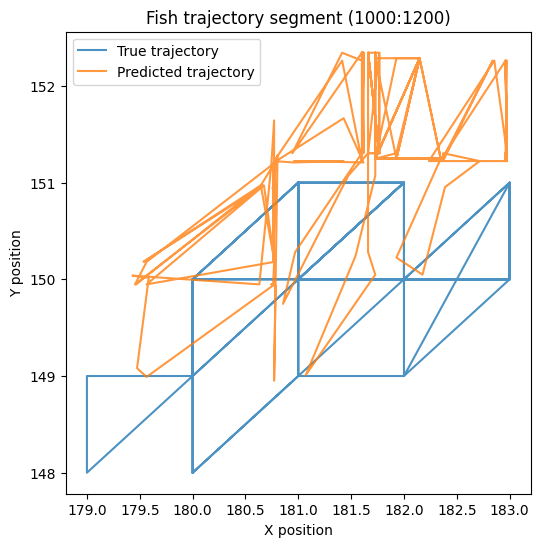

In [18]:
segment_start = 1000  # starting index in test set
segment_length = 200  # number of frames to plot
segment_end = segment_start + segment_length

plt.figure(figsize=(6,6))
plt.plot(
    target_x_test.values[segment_start:segment_end],
    target_y_test.values[segment_start:segment_end],
    label="True trajectory", alpha=0.8
)
plt.plot(
    pred_x[segment_start:segment_end],
    pred_y[segment_start:segment_end],
    label="Predicted trajectory", alpha=0.8
)
plt.legend()
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title(f"Fish trajectory segment ({segment_start}:{segment_end})")
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
import pandas as pd

# --- 1️⃣ Static baseline ---
# Hypothesis: fish does not move (same position and orientation)
baseline_pred_x = df.loc[X_test.index, 'f_x']
baseline_pred_y = df.loc[X_test.index, 'f_y']
baseline_pred_sin = df.loc[X_test.index, 'sin_f_ori']
baseline_pred_cos = df.loc[X_test.index, 'cos_f_ori']

baseline_rmse_x = mean_squared_error(target_x_test, baseline_pred_x, squared=False) / (df['f_x'].max() - df['f_x'].min())
baseline_rmse_y = mean_squared_error(target_y_test, baseline_pred_y, squared=False) / (df['f_y'].max() - df['f_y'].min())
baseline_rmse_sin = mean_squared_error(target_sin_test, baseline_pred_sin, squared=False) / (df['sin_f_ori'].max() - df['sin_f_ori'].min())
baseline_rmse_cos = mean_squared_error(target_cos_test, baseline_pred_cos, squared=False) / (df['cos_f_ori'].max() - df['cos_f_ori'].min())


# --- 2️⃣ Velocity baseline ---
df["vx"] = df["f_x"].diff()
df["vy"] = df["f_y"].diff()
df[["vx", "vy"]] = df[["vx", "vy"]].fillna(0)

# Predict assuming constant velocity for Δt frames
velocity_baseline_pred_x = df.loc[X_test.index, 'f_x'] + delta_t * df.loc[X_test.index, 'vx']
velocity_baseline_pred_y = df.loc[X_test.index, 'f_y'] + delta_t * df.loc[X_test.index, 'vy']

velocity_baseline_rmse_x = mean_squared_error(target_x_test, velocity_baseline_pred_x, squared=False) / (df['f_x'].max() - df['f_x'].min())
velocity_baseline_rmse_y = mean_squared_error(target_y_test, velocity_baseline_pred_y, squared=False) / (df['f_y'].max() - df['f_y'].min())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.

In [20]:
# Build summary table
results_df = pd.DataFrame({
    "Metric": ["X", "Y", "Sin", "Cos"],
    "Model RMSE": [rmse_x_norm, rmse_y_norm, rmse_sin_norm, rmse_cos_norm],
    "Static Baseline RMSE": [baseline_rmse_x, baseline_rmse_y, baseline_rmse_sin, baseline_rmse_cos],
    "Velocity Baseline RMSE": [velocity_baseline_rmse_x, velocity_baseline_rmse_y, "none", "none"]
})

# Format for readability
results_df = results_df.round(4)

# Display nicely
print("📊 Model Performance Summary:\n")
display(
    results_df.style.set_table_styles([
        {"selector": "th", "props": [("font-weight", "bold"), ("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
    .set_caption("Comparison of Model and Baselines (normalized RMSE)")
)

📊 Model Performance Summary:



,Metric,Model RMSE,Static Baseline RMSE,Velocity Baseline RMSE
0,X,0.016100,0.017900,0.033316
1,Y,0.015700,0.017400,0.032205
2,Sin,0.164100,0.174800,none
3,Cos,0.165300,0.177600,none


##  Conclusion : First Week Summary

This notebook concludes my first week of work (9 hours) on the zebrafish behavioral prediction project.  
During this time, I focused on understanding the dataset structure, the preprocessing pipeline (from AllFish_GsizeMotionSingle.ipynb), and setting up a first predictive prototype.

The model aims to describe the full state of the fish, position *(x, y)* and orientation, at future time steps.  
To move quickly, I used a simple XGBoost regressor, prioritizing a working prototype over model optimization.

Despite this simplicity, the results are encouraging:  
the model outperforms both static and velocity baselines in normalized RMSE, showing that it effectively learns patterns from the data rather than random noise.

This establishes a solid foundation to move forward.  
The next steps will include:
- Consolidating this notebooks, making sure it is aligned with behavioral goal, checking no data time leakage ... 
- Developing a neural network model to capture temporal dependencies more efficiently.  
- Integrating bout-level reasoning (possibly detecting decision moments).  

Overall, this prototype validates the approach and confirms that the dataset and modeling setup are sound enough to justify deeper experimentation.